In [28]:
import numpy as np
import matplotlib.pyplot as plt

In [29]:
# constants
EPSILON = 0.1
ALPHA = 0.1
GAMMA = 1.0

A, B, TERM = 0, 1, 2
LEFT, RIGHT = 0, 1
B_ACTIONS = range(10)
ACTIONS = {A: [LEFT, RIGHT], B: B_ACTIONS}

EPISODES = 300
RUNS = 10000

In [30]:
# mdp implementation
class MDP:
    def __init__(self):
        self.reset()

    def reset(self):
        self.state = A
        return self.state

    def step(self, action):
        if self.state == A:
            reward = 0
            if action == LEFT: self.state = B
            else: self.state = TERM
        else:
            reward = np.random.normal(-0.1, 1)
            self.state = TERM
        return self.state, reward


In [31]:
# agent implementation
class Agent:
    def __init__(self, double=False, epsilon=EPSILON, alpha=ALPHA, gamma=GAMMA):
        self.double = double
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
        if self.double:
            self.q1 = [np.zeros(2), np.zeros(len(B_ACTIONS)), np.zeros(1)]
            self.q2 = [np.zeros(2), np.zeros(len(B_ACTIONS)), np.zeros(1)]
        else:
            self.q = [np.zeros(2), np.zeros(len(B_ACTIONS)), np.zeros(1)]

    def act(self, state):
        if np.random.rand() < self.epsilon: 
            action = np.random.choice(ACTIONS[state])
        else: 
            if self.double: q_values = [i + j for i, j in zip(self.q1, self.q2)]
            else: q_values = self.q
            action = np.random.choice(np.where(q_values[state] == np.max(q_values[state]))[0])
        return action

    def learn(self, state, action, reward, next_state):
        if self.double:
            if np.random.rand() < 0.5:
                best_action = np.random.choice(np.where(self.q1[next_state] == np.max(self.q1[next_state]))[0])
                self.q1[state][action] += self.alpha * (reward + self.gamma * self.q2[next_state][best_action] - self.q1[state][action])
            else:
                best_action = np.random.choice(np.where(self.q2[next_state] == np.max(self.q2[next_state]))[0])
                self.q2[state][action] += self.alpha * (reward + self.gamma * self.q1[next_state][best_action] - self.q2[state][action])
        else:
             self.q[state][action] += self.alpha * (reward + self.gamma * np.max(self.q[next_state]) - self.q[state][action])


In [32]:
# generate q data
env = MDP()
q_counts = np.zeros(EPISODES)
for r in range(RUNS):
    agent = Agent()
    for ep in range(EPISODES):
        state = env.reset()
        while state != TERM:
            action = agent.act(state)
            next_state, reward = env.step(action)
            agent.learn(state, action, reward, next_state)
            if state == A and action == LEFT: q_counts[ep] += 1
            state = next_state

q_counts /= RUNS

In [33]:
# generate double q data
env = MDP()
dq_counts = np.zeros(EPISODES)
for r in range(RUNS):
    agent = Agent(double=True)
    for ep in range(EPISODES):
        state = env.reset()
        while state != TERM:
            action = agent.act(state)
            next_state, reward = env.step(action)
            agent.learn(state, action, reward, next_state)
            if state == A and action == LEFT: dq_counts[ep] += 1
            state = next_state

dq_counts /= RUNS

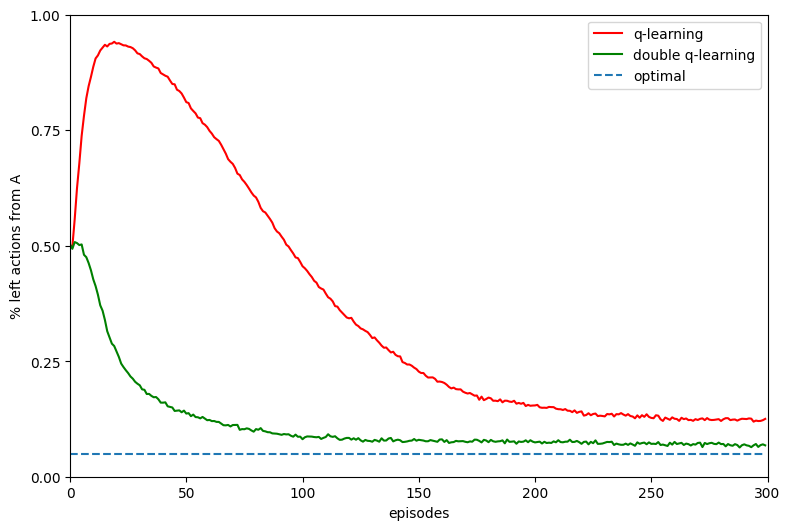

In [34]:
# generate figure

plt.figure(figsize=(9, 6))

plt.plot(q_counts, color='red', label='q-learning')
plt.plot(dq_counts, color='green', label='double q-learning')
plt.plot(np.full(EPISODES, 0.05), linestyle='--', label='optimal')

plt.xlabel('episodes')
plt.xlim(0, 300)
plt.ylabel('% left actions from A')
plt.yticks([0.00, 0.25, 0.50, 0.75, 1.00])
plt.legend()

plt.show()